In [2]:
import requests 
import pyhdf  as hp
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import pickle
import revisedZodiacFunctions as zf


In [3]:
date         = '290515'
gps_filename = 'cal_aco_3840_Latitude_Longitude.hdf'
sat_filename = 'M2015149_sst_comp.hdf'

In [4]:
# ------- Cruise DATA ------- #

with open('track_data.pkl', 'rb') as ztd:
    zodiac_track_data = pickle.load(ztd)

window_size = 25

try:
    # FUNCTION WILL GRAB DICTIONARY WITH CORREPSONDING DATE AND REMOVE NANS AS WELL AS ENSURE DATA IS IN DEFINED BOUNDS OF SMB - EXCLUDING MARINA
    specific_track, lat, lon, SST, flu = zf.track_selector(date, zodiac_track_data, excludenans=True, excludemdr=False)
    print('here')
    # Data Processing, Filtering, & Gradients for SST #
    dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
    grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
    zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
    print('here')
    # Data Processing, Filtering, & Gradients for Flu #
    dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
    grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
    zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)
    print('here')
except:
    pass


here
here
here


In [5]:
specific_track

{'location': (array([-118.44517992, -118.44517991, -118.44517992, ..., -118.4417957 ,
         -118.44179567, -118.44179567]),
  array([33.97641942, 33.97641941, 33.97641939, ..., 33.97822354,
         33.97822355, 33.97822357])),
 'SST': array([19.4307, 19.43  , 19.4292, ..., 19.6776, 19.6771, 19.6767]),
 'Flu': array([391., 392., 392., ..., 396., 397., 397.])}

In [6]:
# ------- GPS DATA ------- #

# Open the HDF4 file in read mode
hdf_file = SD(gps_filename, SDC.READ)

# List all available datasets in the HDF4 file
datasets = hdf_file.datasets()
print("Available datasets:", datasets)

# Access a specific dataset (replace 'dataset_name' with actual dataset name)
lat_dataset = hdf_file.select('Latitude')
lon_dataset = hdf_file.select('Longitude')

# Read data from the selected dataset
lat = lat_dataset.get()
lon = lon_dataset.get()

# Close the HDF4 file after use
hdf_file.end()


Available datasets: {'Latitude': (('fakeDim0', 'fakeDim1'), (3405, 3840), 5, 0), 'Longitude': (('fakeDim2', 'fakeDim3'), (3405, 3840), 5, 1)}


In [7]:
# ------- Sat DATA ------- #

# Open the HDF4 file in read mode
hdf_file = SD(sat_filename, SDC.READ)

# List all available datasets in the HDF4 file
datasets = hdf_file.datasets()
print("Available datasets:", datasets)

# Access a specific dataset (replace 'dataset_name' with actual dataset name)
dataset_name = 'sst_2015149'  # Replace with the name of your dataset
dataset = hdf_file.select(dataset_name)

# Read data from the selected dataset
data = dataset.get()
print("Shape of data:", data.shape)

# Close the HDF4 file after use
hdf_file.end()

data = data.astype(np.int16)

# Bound to SoCal - based on indices of pixel values
data = data[1350:1410,1780:1885]
lat  = lat[1350:1410,1780:1885]
lon  = lon[1350:1410,1780:1885]

# Add 256 to negative values
data[data < 0] += 256

# Exclude pixel boundary values
data[(data == 0) | (data == 255)] = 0

# Adjust pixels to SST
SST = (.15*data) - 3.0
SST[SST == np.max(SST)] = 0

# Close the HDF4 file after use
#hdf_file.end()


Available datasets: {'sst_2015149': (('fakeDim0', 'fakeDim1'), (3405, 3840), 20, 0)}
Shape of data: (3405, 3840)


In [8]:
# Actually ranges of coords 
longitude = np.linspace(np.min(lon), np.max(lon), lon.shape[1])
latitude = np.linspace(np.min(lat), np.max(lat), len(lat))

In [9]:
# ------- Depth/Land DATA ------- #

from netCDF4 import Dataset, num2date

fname = '/home/gstaller/Downloads/crm_socal_1as_vers2.nc'
nc = Dataset(fname)

res = 2

lon, lat = np.array(nc.variables['lon'][::res]), np.array(nc.variables['lat'][::res])
depths = np.array(nc.variables['Band1'][::res, ::res])

lon_min = np.where((lon <= -118.25) & (lon > -118.85))[0][-1]
lon_max = np.where((lon <= -118.25) & (lon > -118.85))[0][0]
lat_min = np.where((lat >= 33.5) & (lat < 34.15))[0][0]
lat_max = np.where((lat >= 33.5) & (lat < 34.15))[0][-1]

depths = depths[lat_min:lat_max, lon_max:lon_min]

lon    = lon[lon_max:lon_min]
lat    = lat[lat_min:lat_max]

lon, lat = np.meshgrid(lon, lat)

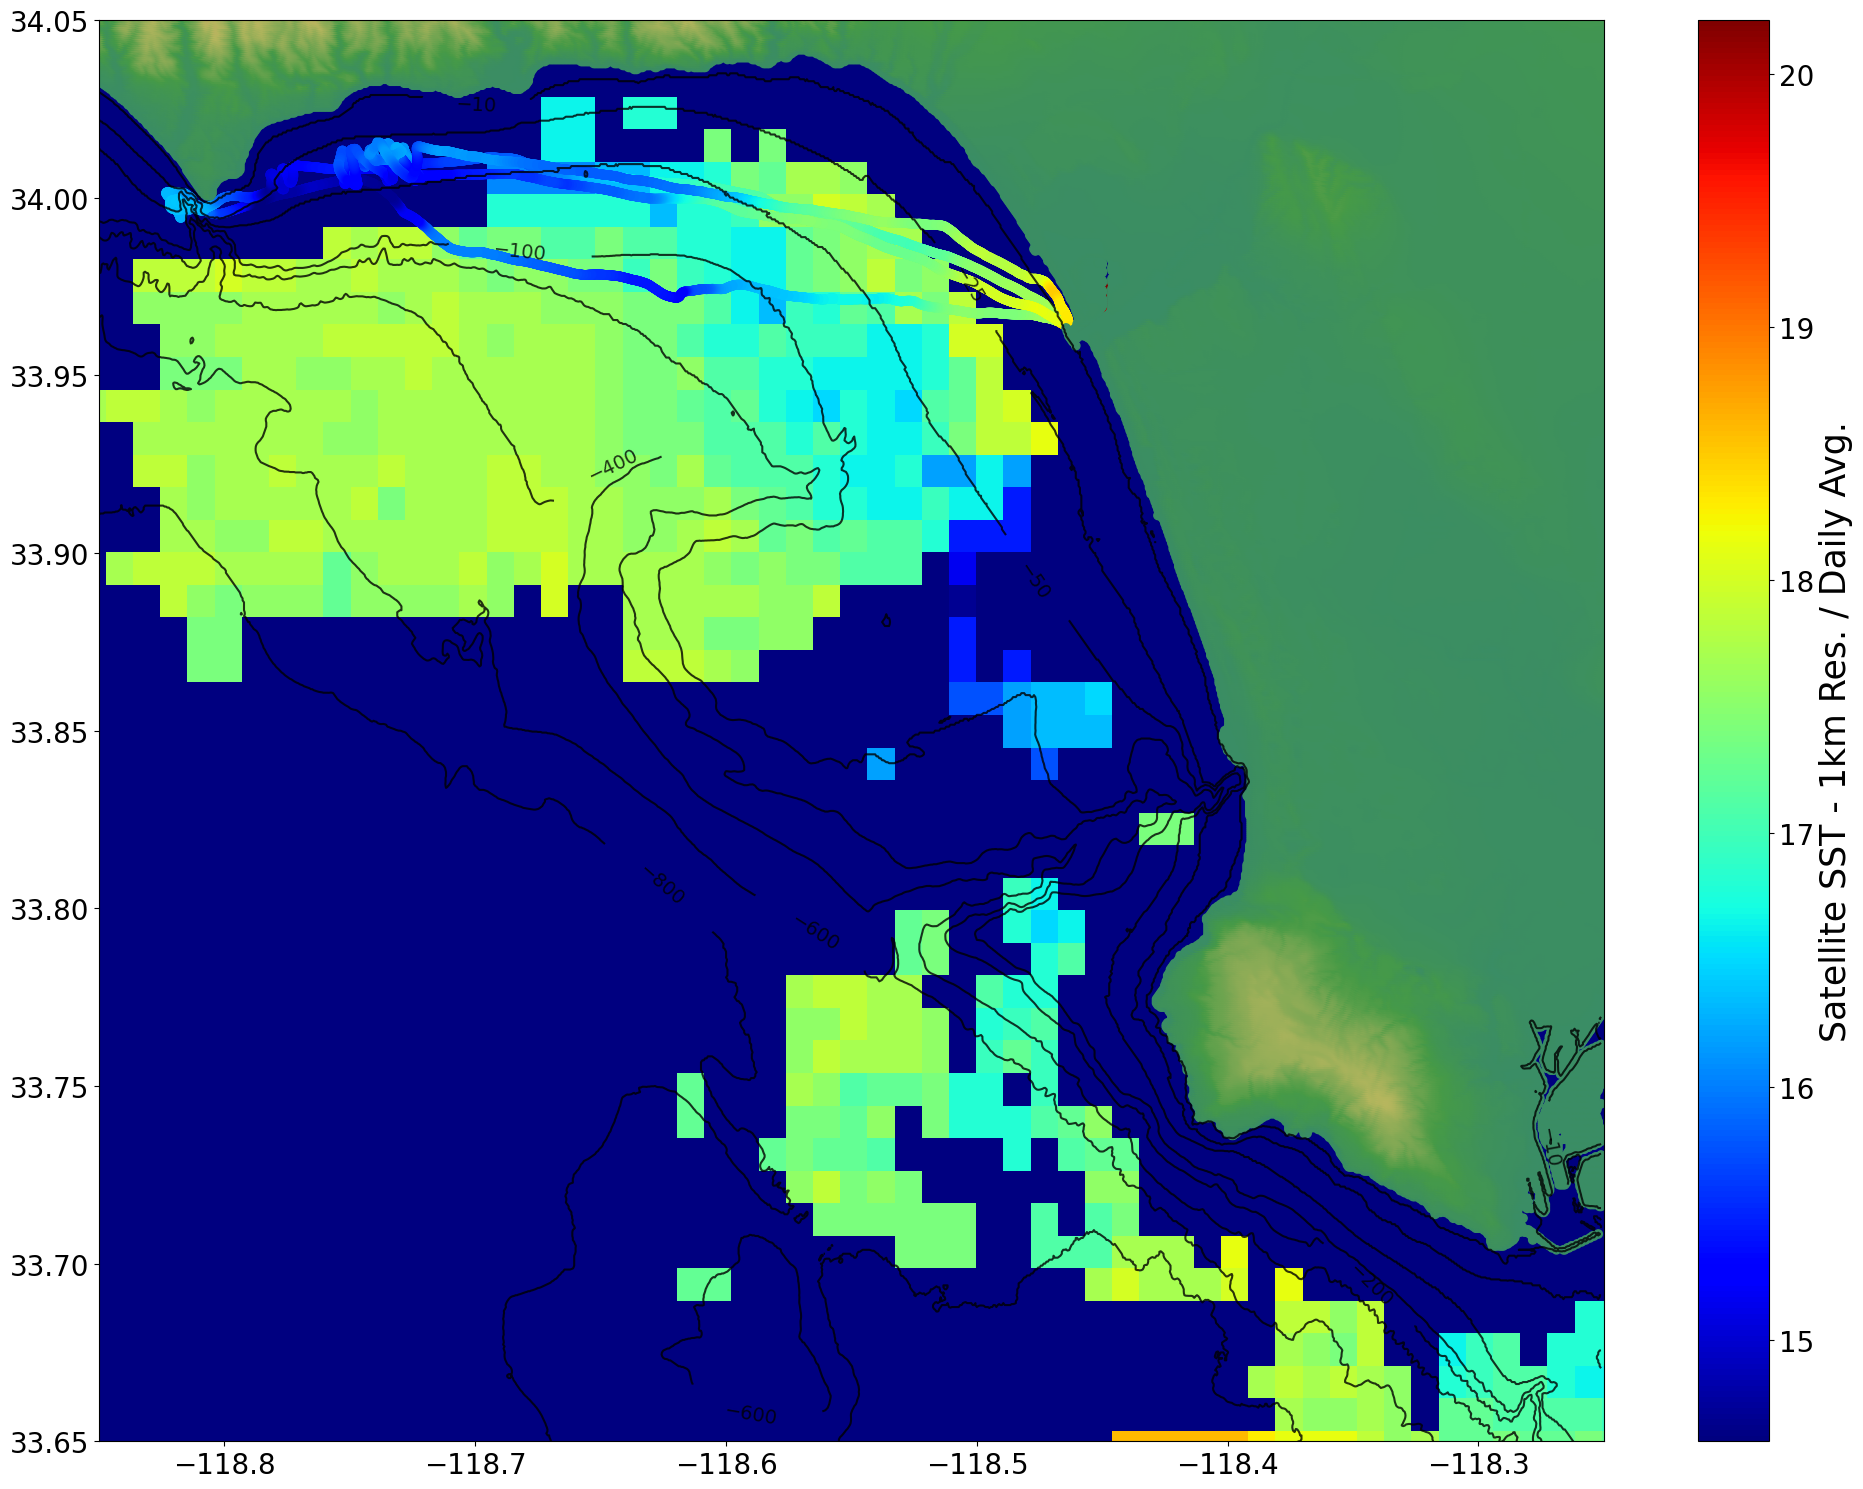

In [29]:
plt.figure(2, (20,15))

# Satellite Data
plt.pcolormesh(longitude, latitude[::-1], SST, cmap = 'jet', vmin = np.min(sst_filtered), vmax = np.max(sst_filtered))
cbar = plt.colorbar()
cbar.set_label('Satellite SST - 1km Res. / Daily Avg.', fontsize = 25)
cbar.ax.tick_params(labelsize = 20)

# Cruise Track 
plt.scatter(lon_sst, lat_sst, c = sst_filtered, cmap='jet', vmin=np.min(sst_filtered), vmax = np.max(sst_filtered))

# Bathymetric Contouts
bathy = plt.contour(lon, lat, depths, [-800, -600, -400, -200, -100, -50, -25, -10], cmap='bone', vmin=-10, alpha = .8)
plt.clabel(bathy, inline = True, fontsize = 14)

# Land Features
terra = plt.scatter(lon[depths > 0], lat[depths > 0], c = depths[depths > 0], cmap = 'gist_earth', vmin = 10)
terra.set_clim(-500)


# Bounds
plt.ylim(33.65, 34.05)
plt.xlim(-118.85, -118.25)

# Ticks
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.tight_layout()

In [11]:
np.max(sst_filtered)

20.21205883989059

In [12]:
specific_track

{'location': (array([-118.44517992, -118.44517991, -118.44517992, ..., -118.4417957 ,
         -118.44179567, -118.44179567]),
  array([33.97641942, 33.97641941, 33.97641939, ..., 33.97822354,
         33.97822355, 33.97822357])),
 'SST': array([19.4307, 19.43  , 19.4292, ..., 19.6776, 19.6771, 19.6767]),
 'Flu': array([391., 392., 392., ..., 396., 397., 397.])}

In [13]:
date

'290515'